<a href="https://colab.research.google.com/github/jigarsanghavi/Brain_Tumor-CNN/blob/master/Brain_tumor_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:00<00:00, 16.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 23.8MB/s]


In [7]:
!unzip /content/brain-mri-images-for-brain-tumor-detection.zip

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tum

In [0]:
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import cv2
from PIL import Image
import imutils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout
import time

In [10]:
classes = [os.listdir('/content/data')]
classes

[['yes', 'no']]

In [0]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [0]:
yes_path = '/content/data/yes'
for filename in os.listdir(yes_path):
  image = cv2.imread(yes_path + '/' + filename)
  image = image.reshape((1,)+image.shape)
  data_gen = ImageDataGenerator(rotation_range=10, 
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1, 
                                 brightness_range=(0.3, 1.0),
                                 horizontal_flip=True, 
                                 vertical_flip=True, 
                                 fill_mode='nearest'
                                )
  i = 0
  for batch in data_gen.flow(x = image,batch_size = 1,save_to_dir = yes_path,save_prefix = 'aug' + filename,save_format = 'jpg'):
    i+=1
    if i > 6:
      break

In [0]:
for filename in os.listdir(yes_path):
  image = cv2.imread(yes_path + '/' + filename)
  image = crop_brain_contour(image,plot = False)
  image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)

In [0]:
no_path = '/content/data/no'
for filename in os.listdir(no_path):
  image = cv2.imread(no_path + '/' + filename)
  image = image.reshape((1,)+image.shape)
  data_gen = ImageDataGenerator(rotation_range=10, 
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1, 
                                 brightness_range=(0.3, 1.0),
                                 horizontal_flip=True, 
                                 vertical_flip=True, 
                                 fill_mode='nearest'
                                )
  i = 0
  for batch in data_gen.flow(x = image,batch_size = 1,save_to_dir = no_path,save_prefix = 'aug' + filename,save_format = 'jpg'):
    i+=1
    if i > 9:
      break

In [0]:
for filename in os.listdir(no_path):
  image = cv2.imread(no_path + '/' + filename)
  image = crop_brain_contour(image,plot = False)
  image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
data = ImageDataBunch.from_folder('data', train=".", valid_pct=0.25,
        ds_tfms=get_transforms(), bs=8, size=224, num_workers=4).normalize(imagenet_stats)

In [18]:
data.classes

['no', 'yes']

In [19]:
print(len(data.train_ds),len(data.valid_ds))

1739 579


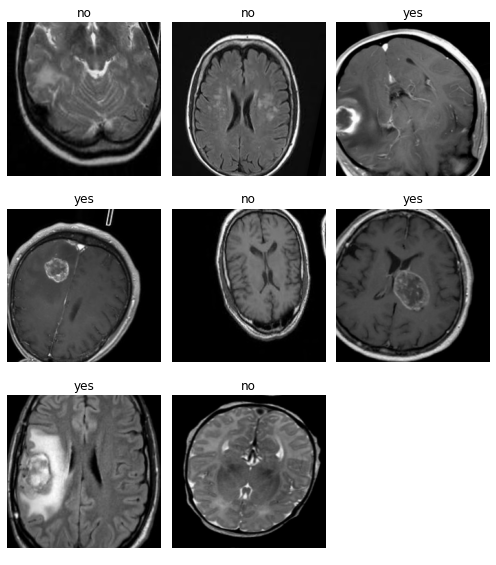

In [20]:
data.show_batch(rows=5, figsize=(7,8))

In [21]:
precision=Precision()
recall=Recall()
AUC=AUROC()
learn = cnn_learner(data, models.resnet50, metrics=(accuracy,precision,recall,AUC),callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.690155,0.482678,0.846287,0.828313,0.895765,0.915717,00:46
1,0.496034,0.190168,0.930915,0.915888,0.957655,0.977953,00:43
2,0.408188,0.249007,0.906736,0.970260,0.850163,0.976384,00:44
3,0.298621,0.117165,0.949914,0.979310,0.925081,0.995629,00:44
4,0.292308,0.058780,0.982729,0.990099,0.977199,0.998371,00:43
5,0.272640,0.028228,0.991364,0.993464,0.990228,0.999820,00:43
6,0.162298,0.031540,0.993092,1.000000,0.986971,0.999928,00:43
7,0.155637,0.034912,0.993092,1.000000,0.986971,0.999940,00:43
8,0.113222,0.017660,0.994819,0.996732,0.993485,0.999904,00:43
9,0.133014,0.015462,0.996546,0.996743,0.996743,0.999928,00:43


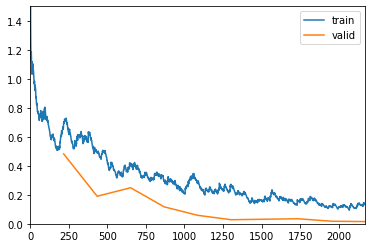

In [22]:
learn.fit_one_cycle(10)

In [0]:
learn.save("Brain Tumor CNN")

In [24]:
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
x0 = []
y0 = []
path='/content/data/yes'
for filename in os.listdir(path):
   img = image.load_img(path+'/'+filename, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
   x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
   x = np.expand_dims(x, axis=0)
   img = preprocess_input(x)
   x0.append(img)
   y0.append([0])


Using TensorFlow backend.


In [0]:
x1 = []
y1 = []
path='/content/data/no'
for filename in os.listdir(path):
   img = image.load_img(path+'/'+filename, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
   x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
   x = np.expand_dims(x, axis=0)
   img = preprocess_input(x)
   x1.append(img)
   y1.append([1])



In [26]:
img_data=x0+x1
img_data = np.asanyarray(img_data)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(2318, 1, 224, 224, 3)
(1, 2318, 224, 224, 3)
(2318, 224, 224, 3)


In [27]:
labels = y0+y1
labels = np.asanyarray(labels)
from keras.utils import to_categorical
labels = to_categorical(labels)
labels.shape

(2318, 2)

In [0]:
x_train,x_val,y_train,y_val = train_test_split(img_data,labels,test_size = 0.25)


In [31]:
image_input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
last_layer = model.get_layer('avg_pool').output
out = Dense(2, activation='softmax', name='output_layer')(last_layer)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

for layer in custom_resnet_model.layers[:-1]:
	layer.trainable = False

custom_resnet_model.layers[-1].trainable

custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
hist = custom_resnet_model.fit(x_train, y_train, batch_size=8, epochs=12, verbose=1, validation_data=(x_val, y_val))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model.evaluate(x_val, y_val, batch_size=8, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [32]:
filepath = '/content/tensorflow resnet50 model'
tf.keras.models.save_model(
    custom_resnet_model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/tensorflow resnet50 model/assets
